<a href="https://colab.research.google.com/github/L1MOJ/EE290-2-HW-for-ML/blob/main/EE290_2_Hardware_For_ML_Sp21_Lab_1_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

Before beginning the assignment, we import the CIFAR dataset, and train a simple convolutional neural network (CNN) to classify it.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

Load training and test data from the CIFAR10 dataset.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 48508117.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Define a simple CNN that classifies CIFAR images.
The network provided is similar to LeNet-5, and it has the following architecture:

**Layer** | **Type** | **Input Shape** | **Output Shape** | **Activation**
--- | --- | --- | --- | ---
conv1 | Convolutional | 3x32x32 | 6x28x28 | ReLU
pool1 | Max pool | 6x28x28 | 6x14x14 | None                
conv2 | Convolutional | 6x14x14 | 16x10x10 | ReLU                
pool2 | Max pool | 16x10x10 | 16x5x5 | None                
fc1 | Fully-connected | 400 | 120 | ReLU                
fc2 | Fully-connected | 120 | 84 | ReLU                
fc3 | Fully-connected | 84 | 10 | None                

None of the layers in the network have a bias associated with them.
This makes them easier to quantize.
Towards the end of this assignment, we will add biases to the final layer and quantize it as well.

In [5]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
    self.fc1 = nn.Linear(400, 120, bias=False)
    self.fc2 = nn.Linear(120, 84, bias=False)
    self.fc3 = nn.Linear(84, 10, bias=False)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.reshape(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x



# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
#         self.pool = nn.MaxPool2d(2, 2) # run after each conv (hence the 5x5 FC layer)
#         self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
#         self.fc2 = nn.Linear(120, 84, bias=False)
#         self.fc3 = nn.Linear(84, 10, bias=False)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [6]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
  for epoch in range(2):
    running_loss = 0.0
    for i, (X, y) in enumerate(dataloader, 0):
      X = X.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      y_hat = model(X)
      l = criterion(y_hat, y)
      l.backward()
      optimizer.step()
      running_loss += l.item()

      if i % 2000 == 1999:
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0
  print('Finished Training')


# def train(model: nn.Module, dataloader: DataLoader):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#     for epoch in range(2):  # loop over the dataset multiple times

#         running_loss = 0.0
#         for i, data in enumerate(dataloader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             inputs, labels = data

#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             # print statistics
#             running_loss += loss.item()
#             if i % 2000 == 1999:    # print every 2000 mini-batches
#                 print('[%d, %5d] loss: %.3f' %
#                     (epoch + 1, i + 1, running_loss / 2000))
#                 running_loss = 0.0

#     print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # get 1 batch worth of image predictions (i.e. 4 predictions of 10 each)
            other, predicted = torch.max(outputs.data, 1) # other == values, predicted == indicies
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break

    return 100 * correct / total

In [7]:
train(net, trainloader)

[1,  2000] loss: 2.213
[1,  4000] loss: 1.904
[1,  6000] loss: 1.702
[1,  8000] loss: 1.620
[1, 10000] loss: 1.533
[1, 12000] loss: 1.509
[2,  2000] loss: 1.427
[2,  4000] loss: 1.403
[2,  6000] loss: 1.389
[2,  8000] loss: 1.346
[2, 10000] loss: 1.349
[2, 12000] loss: 1.345
Finished Training


Now that the CNN has been trained, let's test it on our test dataset.

In [8]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

100%|██████████| 2500/2500 [00:07<00:00, 327.45it/s]

Accuracy of the network on the test images: 51.72%


Define a convenience function which we use to copy CNN's.

In [9]:
from copy import deepcopy

def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

# Question 1: Visualize Weights

## Question 1.1:

Plot histograms of the weights of every convolutional and fully-connected layer. Record any observations you make about the distribution of the values.

In [10]:
import matplotlib.pyplot as plt
import numpy as np

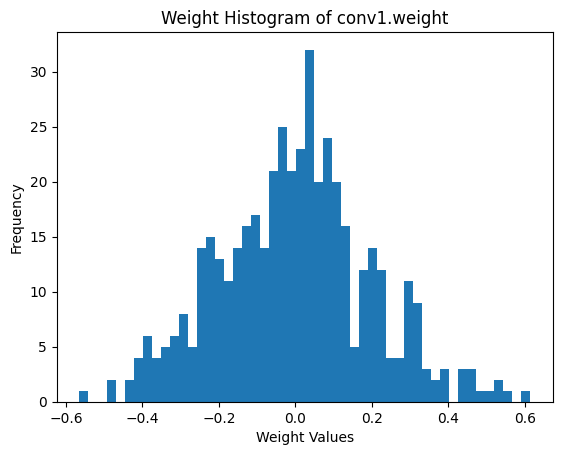

conv1.weight weights range: 1.1793382167816162
3sigma range: 1.1957889795303345


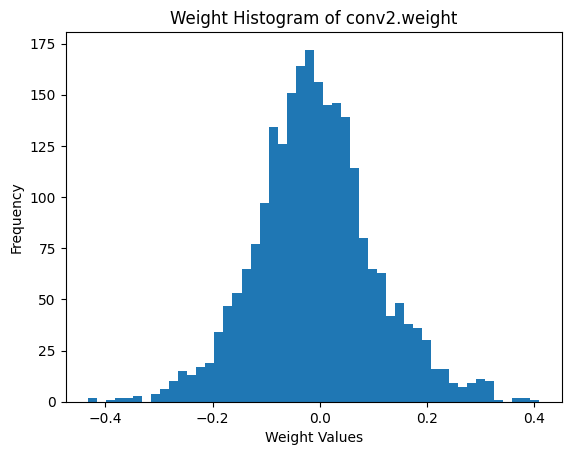

conv2.weight weights range: 0.8411538898944855
3sigma range: 0.6725354194641113


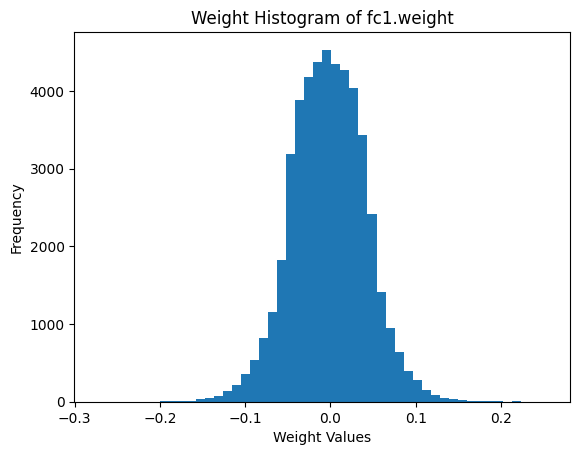

fc1.weight weights range: 0.5285523235797882
3sigma range: 0.2600101828575134


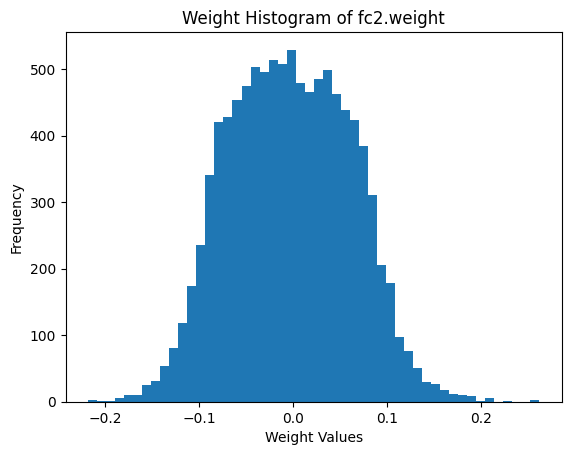

fc2.weight weights range: 0.4795065224170685
3sigma range: 0.38533294200897217


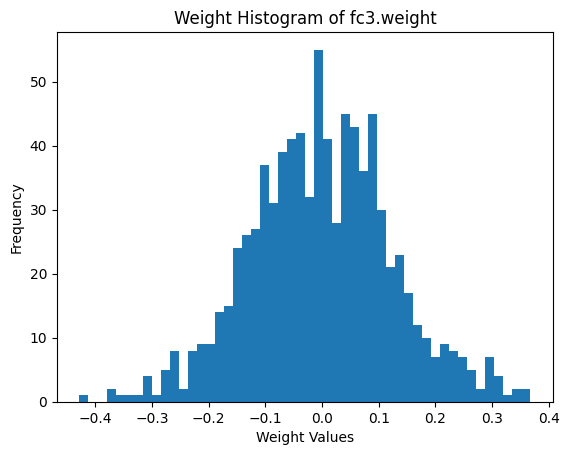

fc3.weight weights range: 0.7953547239303589
3sigma range: 0.7580729722976685


In [11]:
# ADD YOUR CODE HERE to plot distributions of weights

# You can get a flattened vector of the weights of fc1 like this:
#   fc1_weights = net.fc1.weight.data.cpu().view(-1)
# Try plotting a histogram of fc1_weights (and the weights of all the other layers as well)
copyed = copy_model(net)

for name, param in copyed.named_parameters():
  if 'weight' in name:
    weights = param.data.cpu().view(-1)
    weights_3sigma_max = (weights.mean() + 3*weights.std()).item()
    weights_3sigma_min = (weights.mean() - 3*weights.std()).item()
    plt.figure()
    plt.hist(weights, bins=50)
    plt.xlabel('Weight Values')
    plt.ylabel('Frequency')
    plt.title(f'Weight Histogram of {name}')
    # 显示图形
    plt.show()
    print(f'{name} weights range: {weights.max().item() - weights.min().item()}')
    print(f'3sigma range: {weights_3sigma_max - weights_3sigma_min}')
    # print(f"Layer:{name} weight are {param.data.cpu().view(-1)}")

## Question 1.2:

Record the range of the weights, as well as their 3-sigma range (the difference between $\mu + 3\sigma$ and $\mu - 3\sigma$).
For which layers is the 3-sigma range larger or smaller than the actual range?
Then explain which range you would prefer to use if you were to quantize each layer's weights and wanted to strike a balance between the range of values that could be expressed, and your precision.

In [12]:
# ADD YOUR CODE HERE to record the range of the weights

# Question 2: Quantize Weights

Any convolution or fully-connected layer pass, without a bias, can be described by the equation:

$$W*In = Out$$

where $W$ is the weight tensor, $In$ in the input tensor, and $Out$ is the output tensor.

For this question, your task is to find a *scaling factor*, called $n_W$ for each convolutional and fully connected layer,
which would fit inside an 8-bit signed integer.
This equation can now be described as the following:

$$n_WW*In = n_WOut$$

You might wonder: "Isn't it a problem that the output of the layer has now changed? Wouldn't quantizing the weights change the output of the neural net?"

The answer, of course, is: "Yes".
However, what we care about is not the *absolute* values output by the CNN, but the relative difference between the probabilities it assigns to different classes for its predictions.
Quantizing the weights only scales this relative difference up or down, but it does not affect which class the network assigns the most probability to.
Therefore, it does not affect the final predictions that the neural net makes.

Copy the old model into a new model.

In [13]:
net_q2 = copy_model(net)

## Question 2.1:

Fill in the `quantized_weights` function.
The template code we provide will then call this function on the weights of every layer in the CNN that we just trained at 32-bit floating point precision, to lower them into 8-bit signed integer precision.

In [14]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    # ADD YOUR CODE HERE
    max_ = weights.view(-1).max().item()
    min_ = weights.view(-1).min().item()

    max_mag = max(abs(max_), abs(min_))
    range = max_mag

    scale = 127.0 / range
    result = (weights * scale).round()
    return torch.clamp(result, min=-128, max=127), scale

In [15]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

## Question 2.2:

Record the accuracy change of the network after quantizing its weights.
If you’ve done everything correctly, the accuracy change should be negligible.

In [16]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

100%|██████████| 2500/2500 [00:07<00:00, 331.83it/s]

Accuracy of the network after quantizing all weights: 51.71%


# Question 3: Visualize Activations

Now that we have quantized the weights of the CNN, we must also quantize the activations (inputs and outputs to layers) traveling through it.
But before doing so, let's analyze what values the activations take when travelling through the network.

We provide convenience code which will record the values of every pixel of the outputs and inputs travelling through the neural network.
(This is the initial CNN, where not even the weights had yet been quantized).
We then profile these values when running on a subset of the training set.

In [17]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


Use the unquantized model to profile input and output activations on a subset of the training dataset.

In [18]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

  1%|          | 100/12500 [00:00<01:17, 159.80it/s]


In [19]:
input_activations = net_q3.input_activations
conv1_output_activations = net_q3.conv1.activations
conv2_output_activations = net_q3.conv2.activations
fc1_output_activations = net_q3.fc1.activations
fc2_output_activations = net_q3.fc2.activations
fc3_output_activations = net_q3.fc3.activations

## Question 3.1:

Plot histograms of the input images and the outputs of every convolutional and fully-connected layer.
Record any observations you make about the distribution of the values.

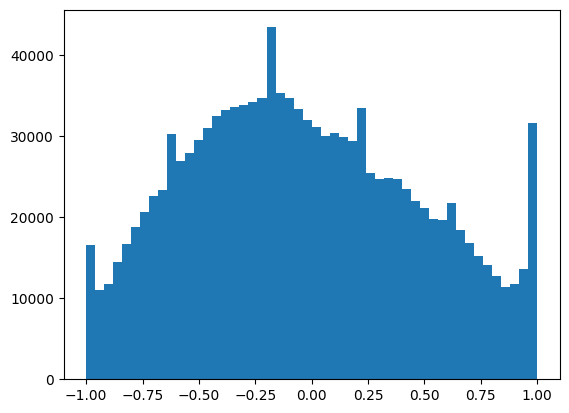

input range: 2.0
input 3-sigma range: 3.035374315788


In [20]:
# ADD YOUR CODE HERE to plot distributions of activations

# Plot histograms of the following variables, and calculate their ranges and 3-sigma ranges:
#   input_activations
#   conv1_output_activations
#   conv2_output_activations
#   fc1_output_activations
#   fc2_output_activations
#   fc3_output_activation
plt.hist(input_activations, bins=50)
plt.show()

input_activations_3sigma_max = (input_activations.mean() + 3*input_activations.std()).item()
input_activations_3sigma_min = (input_activations.mean() - 3*input_activations.std()).item()

print("input range: {}".format((input_activations.max() - input_activations.min()).item()))
print("input 3-sigma range: {}".format(input_activations_3sigma_max - input_activations_3sigma_min))

## Question 3.2:

Additionally, record the range of the values, as well as their 3-sigma range (the difference between $\mu + 3\sigma$ and $\mu - 3\sigma$).
For which layers is the 3-sigma range larger or smaller than the actual range?
Then explain which range you would prefer to use if you were to quantize each layer's weights and wanted to strike a balance between the range of values that could be expressed, and your precision.
Remember that you are plotting the activations *after* activation functions like ReLU have been applied, which means that you should not be worried if you find that your plots are asymmetric.

In [21]:
# ADD YOUR CODE HERE to record the range of the weights

# Question 4: Quantize Activations

Now it is time to quantize the activations (inputs and outputs to layers) traveling through the CNN.
Our equation now becomes:

$$n_WW*n_{In}In*n_{Out} = n_Wn_{In}n_{Out}Out$$

where $n_{In}$ is the scaling factor which was applied to the input to the layer, and $n_{Out}$ is the scaling factor which we decide to apply to the output of the layer.
$n_{Out}$ must be chosen such that the expected values of the elements of $Out$ can be scaled down to fit within 8 bits.

## Question 4.1:

Before performing any quantization at all, we could describe the output of the `conv1` layer as:

$$W_{conv1} * In = Out_{conv1}$$

Suppose that we quantized the input matrix, $In$, scaling it down by $n_{In}$.
Suppose that we also scaled the weight matrix, $W_{conv1}$, by $n_{W_{conv1}}$, and the output matrix, $Out_{conv1}$, by $n_{Out_{conv1}}$.

In the lab report answer the following sub-questions for **4.1.**:

**(a)** Write an equation describing the output of the `conv1` layer with these new scaling parameters.

**(b)** Write an equation describing the output of the `conv2` layer in terms of $In$, $W_{conv1}$, $W_{conv2}$, $Out_{conv1}$, $Out_{conv2}$, $n_{In}$, $n_{W_{conv1}}$, $n_{W_{conv2}}$, $n_{Out_{conv1}}$, and $n_{Out_{conv2}}$.
You can pretend that the pooling layers do not exist.

## Question 4.2:

Complete the `quantize_initial_input` and `quantize_activations` functions which calculate the scaling factors for the initial image which is input to the CNN, and the outputs of each layer, respectively.

## Question 4.3:

Complete the `forward` function for the `NetQuantized` class.
You will have to add code here to scale the outputs of each layer, and then to clamp the outputs of each layer to integers between -128 and 127 afterwards.

In [22]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()

        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale,
                                          self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD YOUR CODE HERE
        max_ = pixels.max().item()
        min_ = pixels.min().item()

        max_mag = max(abs(max_), abs(min_))
        range = max_mag
        scale = 127.0 / range
        return scale

    @staticmethod
    def quantize_activations(activations: np.ndarray, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        n_w (float): The scale by which the weights of this layer were multiplied as part of the
        "quantize_weights" function you wrote earlier
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale"
        and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''
        activations *= n_initial_input

        for nw, nout in ns:
          activations *= nw * nout
        activations *= n_w

        max_ = activations.max().item()
        min_ = activations.min().item()

        max_mag = max(abs(max_), abs(min_))
        range = max_mag
        scale = 127.0 / range
        # ADD YOUR CODE HERE
        # Here we compute the overall scale, therefore we have to take into acount of all the
        # previous scales
        return scale

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale

        # To make sure that the outputs of each layer are integers between -128 and 127, you may need to use the following functions:
        #   * torch.Tensor.round
        #   * torch.clamp

        # ADD YOUR CODE HERE
        x = torch.clamp(x * self.input_scale, min=-128, max=127).round()

        x = self.pool(F.relu(self.conv1(x)))
        x = torch.clamp(x * self.conv1.output_scale, min=-128, max=127).round()

        x = self.pool(F.relu(self.conv2(x)))
        x = torch.clamp(x * self.conv2.output_scale, min=-128, max=127).round()

        x = x.view(-1, 16 * 5 * 5)

        x = F.relu(self.fc1(x))
        x = torch.clamp(x * self.fc1.output_scale, min=-128, max=127).round()

        x = F.relu(self.fc2(x))
        x = torch.clamp(x * self.fc2.output_scale, min=-128, max=127).round()

        x = F.relu(self.fc3(x))
        x = torch.clamp(x * self.fc3.output_scale, min=-128, max=127).round()

        return x

In [23]:
# Merge the information from net_q2 and net_q3 together
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

## Question 4.4:

Finally, record the accuracy of your network after both weights and activations have been quantized.
If you've done everything right, you should still find almost no accuracy change.

In [24]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

100%|██████████| 2500/2500 [00:11<00:00, 223.89it/s]

Accuracy of the network after quantizing both weights and activations: 51.55%


# Question 5: Quantize Biases

Let us now update our CNN to include a bias in its final layer, *fc3*.
We have already included code to create and train a new CNN called `net_with_bias`.

Consider how a bias affects the equation for an unquantized layer:

$$W * In + \beta = Out$$

where $\beta$ is the bias.

## Question 5.1:

Suppose that we again quantized a biased layer with the same scaling factors we used in previous questions: $n_W$, $n_{In}$, and $n_{Out}$.
What would we scale $\beta$ by in this case?
Write an equation in your lab report to describe the output of the quantized layer with a bias.

Create a new network with a bias on *fc3*.

In [25]:
class NetWithBias(nn.Module):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_bias = NetWithBias().to(device)

Train and score the network.

In [26]:
train(net_with_bias, trainloader)

[1,  2000] loss: 2.241
[1,  4000] loss: 1.934
[1,  6000] loss: 1.698
[1,  8000] loss: 1.621
[1, 10000] loss: 1.542
[1, 12000] loss: 1.509
[2,  2000] loss: 1.415
[2,  4000] loss: 1.408
[2,  6000] loss: 1.364
[2,  8000] loss: 1.368
[2, 10000] loss: 1.327
[2, 12000] loss: 1.314
Finished Training


In [27]:
score = test(net_with_bias, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))

100%|██████████| 2500/2500 [00:08<00:00, 293.39it/s]

Accuracy of the network (with a bias) on the test images: 54.92%


Test the network with quantized weights but unquantized bias.

In [28]:
register_activation_profiling_hooks(net_with_bias)
test(net_with_bias, trainloader, max_samples=400)
net_with_bias.profile_activations = False

  1%|          | 100/12500 [00:00<01:15, 164.37it/s]


In [29]:
net_with_bias_with_quantized_weights = copy_model(net_with_bias)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

100%|██████████| 2500/2500 [00:07<00:00, 330.79it/s]

Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 49.81%


## Question 5.2:

Fill in the `quantized_bias` function in the `NetQuantizedWithBias` class.
This function is meant to quantize the bias on the final layer of the CNN.
Keep in mind that biases are typically quantized to 32-bits, so your bias values do not all have to be between -128 and 127 (though 32-bits is a bit conservative).

In [32]:
# slightly clearer bias bounds (32b signed integer)
MIN_32B_SINT = -(2**31)
MAX_32B_SINT = (2**31) - 1

In [30]:
class NetQuantizedWithBias(NetQuantized):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized)

        preceding_scales = [(layer.weight.scale, layer.output_scale) for layer in self.children() if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)][:-1]

        #print(self.fc3.bias.data)
        self.fc3.bias.data = NetQuantizedWithBias.quantized_bias(
            self.fc3.bias.data,
            self.fc3.weight.scale,
            self.input_scale,
            preceding_scales
        )
        #print(self.fc3.bias.data)

        if (self.fc3.bias.data < MIN_32B_SINT).any() or (self.fc3.bias.data > MAX_32B_SINT).any():
            raise Exception("Bias has values which are out of bounds for an 32-bit signed integer")
        if (self.fc3.bias.data != self.fc3.bias.data.round()).any():
            raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between MIN_32B_SINT and MAX_32B_SINT.

        Parameters:
        bias (Tensor): The floating point values of the bias
        n_w (float): The scale by which the weights of this layer were multiplied
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between MIN_32B_SINT and MAX_32B_SINT.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''
        scale = n_w
        scale *= n_initial_input
        for nw, nout in ns:
          scale *= nw * nout
        # ADD YOUR CODE HERE
        return torch.clamp((bias * scale).round(), min=MIN_32B_SINT, max=MAX_32B_SINT)

In [33]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

## Question 5.3:

What is your accuracy before and after quantizing CNN with the bias?
The accuracy change should ideally be negligible.

In [34]:
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights and the bias are quantized: {}%'.format(score))

100%|██████████| 2500/2500 [00:11<00:00, 211.80it/s]

Accuracy of the network on the test images after all the weights and the bias are quantized: 54.84%
